In [2]:
import scipy
import random
import portpy.photon as pp
import numpy as np
from cvxpy import *
from scipy import sparse
import sklearn.metrics
import cProfile
import time
import sys
import psutil
from sklearn.decomposition import PCA
from scipy.linalg import hadamard
import matplotlib.pyplot as plt
import cvxpy as cp
from scipy.optimize import lsq_linear
import scipy.sparse

In [3]:
data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
structs.create_opt_structures(opt_params)
inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)
plan_sparse = pp.Plan(ct, structs, beams, inf_matrix_sparse, clinical_criteria)
opt = pp.Optimization(plan_sparse, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_sparse = opt.solve(solver='MOSEK', verbose=True)
dose_sparse_1d = plan_sparse.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions())
x_sparse =sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions()

beams_full = pp.Beams(data, load_inf_matrix_full=True)
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
plan_full = pp.Plan(ct, structs, beams, inf_matrix_full, clinical_criteria)
dose_full_1d = plan_full.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_full.get_num_of_fractions())

A_dense = plan_full.inf_matrix.A
A_sparse = plan_sparse.inf_matrix.A


creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.5.1                                    
(CVXPY) Jun 06 12:53:03 AM: Your problem has 1946 variables, 110663 constraints, and 0 parameters.
(CVXPY) Jun 06 12:53:03 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 06 12:53:03 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jun 06 12:53:03 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 06 12:53:03 AM: Your problem is compiled with the CPP canonicalization backend.
------------------------------------

(CVXPY) Jun 06 12:53:06 AM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Jun 06 12:53:06 AM:   Solution status : OPTIMAL
(CVXPY) Jun 06 12:53:06 AM:   Primal.  obj: 4.2045404128e+01    nrm: 1e+02    Viol.  con: 5e-06    var: 6e-07    cones: 0e+00  
(CVXPY) Jun 06 12:53:06 AM:   Dual.    obj: 4.2045404171e+01    nrm: 6e+03    Viol.  con: 0e+00    var: 1e-08    cones: 0e+00  
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Jun 06 12:53:06 AM: Problem status: optimal
(CVXPY) Jun 06 12:53:06 AM: Optimal value: 4.205e+01
(CVXPY) Jun 06 12:53:06 AM: Compilation took 1.026e+00 seconds
(CVXPY) Jun 06 12:53:06 AM: Solver (including time spent in interface) took 1.843e+00 seconds
Creating BEV..
Loading full influence matrix..
Done


In [4]:
# specify the patient data location.
data_dir = r'../data'
# Use PortPy DataExplorer class to explore PortPy data
data = pp.DataExplorer(data_dir=data_dir)
# display the existing patients in console or browser.
data.display_list_of_patients()

,patient_id,disease_site,ptv_vol_cc,num_beams
0,Lung_Phantom_Patient_1,Lung,43.902,72


In [5]:
# pick a patient from the existing patient list to get detailed info (e.g., beam angles, structures).
data.patient_id = 'Lung_Phantom_Patient_1'
# display the data of the patient in console or browser.
beams_df, structs_df = data.display_patient_metadata(return_beams_df=True, return_structs_df=True)
beams_df.head()

,ID,gantry_angle,collimator_angle,couch_angle,beam_modality,energy_MV,influence_matrix(sparse/full),iso_center,MLC_name,machine_name
0,0,0,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
1,1,5,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
2,2,10,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
3,3,15,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM
4,4,20,0,0,Photon,6,Both,"{'x_mm': 79.47996, 'y_mm': 134.0219, 'z_mm': 3...",VARIAN MILLENIUM 120,VARIAN TRUE BEAM


In [6]:
structs_df.head()

,name,volume_cc
0,GTV,27.629362
1,LUNGS_NOT_GTV,2983.244630
2,PTV,43.901787
3,CORD,5.307685
4,HEART,841.405457


In [7]:
# Get the threshold value used by PortPy to truncate the matrix    
# sparse tol is 1% of the maximum of influence matrix of planner beams

start_time = time.time()

# The sparse and full matrices are both pre-calculated and included in PorPy data.
#   The sparse matrix; however, was obtained by simply zeroing out the small elements in the full matrix that were
#   less than a threshold specified in "my_plan.inf_matrix.sparse_tol". Here, we manually generate the sparse
#   matrix from the full matrix using this threshold to clarify the process

#  Get A_sparse and A_dense
A_dense = plan_full.inf_matrix.A
A_sparse = plan_sparse.inf_matrix.A

# Get the threshold value used by PortPy to truncate the matrix
# sparse tol is 1% of the maximum of influence matrix of planner beams
sparse_tol = plan_sparse.inf_matrix.sparse_tol
# sparse_tol = 0.01*np.amax(A_dense)

# Truncate the full matrix
A_dense[A_dense <= sparse_tol] = 0
test = np.abs(A_dense - A_sparse.todense()) <= 1e-3

# Check if both influence matrices agree
assert test.all()

end_time = time.time()
total_execution_time = end_time - start_time
print(f"زمان کل اجرای ساخت ماتریس پراکنده  \t: {total_execution_time} ثانیه")

زمان کل اجرای ساخت ماتریس پراکنده  	: 0.21366620063781738 ثانیه


In [8]:
print(test)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]


In [9]:
print("A_dense:")
print(A_dense[1:7, 0:23])

print("A_sparse:")
print(A_sparse)

print("\nA_sparse:")
print((A_sparse.todense())[1:7, 0:23])


A_dense:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
A_sparse:
  (9917, 233)	0.016086647
  (9918, 233)	0.017288812
  (9919, 233)	0.017336378
  (10040, 234)	0.01604795
  (10041, 234)	0.016188115
  (10042, 234)	0.016508544
  (10043, 234)	0.017050294
  (10044, 234)	0.018119987
  (10045, 234)	0.01847046
  (10046, 234)	0.016722668
  (10101, 235)	0.016639015
  (10102, 235)	0.016785383
  (10103, 235)	0.016535586
  (10104, 235)	0.01627703
  (10105, 235)	0.016100962
  (10108, 235)	0.016029088
  (10508, 77)	0.016020946
  (10626, 77)	0.016256336
  (10627, 78)	0.016463526
  (10682, 77)	0.016085567
  (10739, 78)	0.01

In [13]:
A_sparse.todense().shape

(60183, 542)

In [14]:
A_hat = A_sparse
A = A_dense
p = dose_full_1d
print(f' A_hat = {A_hat.shape}\n A = {A.shape}\n p = {p.shape}')

 A_hat = (60183, 542)
 A = (60183, 542)
 p = (60183,)


<center> 
Minimize $\lVert Ax - p \rVert_{2}^2$
</center>
<center>
subject to $x \succeq 0$
</center>

                                                            p = دوزتجویزی

In [21]:
start_time = time.time()

# حل مسئله کمترین مربعات با قید نامنفی بودن x
sol_dense = lsq_linear (A, p, bounds=(0, np.inf))

end_time = time.time ()

total_execution_time = end_time - start_time
print(f"زمان حل مسُله  {total_execution_time} ثانیه")

# چاپ بردار x بهینه
# print(f"بردار x بهینه: {result.x}")


زمان حل مسُله  0.5927515029907227 ثانیه


<center> 
Minimize $\lVert A^*x - p \rVert_{2}^2$
</center>
<center>
subject to $x \succeq 0$
</center>

In [22]:
start_time = time.time()

# حل مسئله کمترین مربعات با قید نامنفی بودن x
sol_sparse = lsq_linear (A_hat ,  p, bounds=(0, np.inf))

end_time = time.time()

total_execution_time = end_time - start_time
print(f"زمان حل مسُله  {total_execution_time} ثانیه")

# print(f"بردار x بهینه: {x_JL_1.x}")


زمان حل مسُله  0.19490408897399902 ثانیه


In [23]:
sol_sparse

       message: The unconstrained solution is optimal.
       success: True
        status: 3
           fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
             x: [ 9.622e+00  2.369e+00 ...  1.095e+00  6.576e+00]
           nit: 0
          cost: 44138.278491278164
    optimality: 4.02296907429673e-09
   active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 unbounded_sol: (array([ 9.622e+00,  2.369e+00, ...,  1.095e+00,  6.576e+00]), 2, 85, 297.1137105260492, 1.8880159324568982e-08, 87.85576648995347, 3.505247262610761, 255.93518980671277)

In [27]:
x_sparse = sol_sparse.x
x_sparse = sol_dense.x

   ## DVH Plot

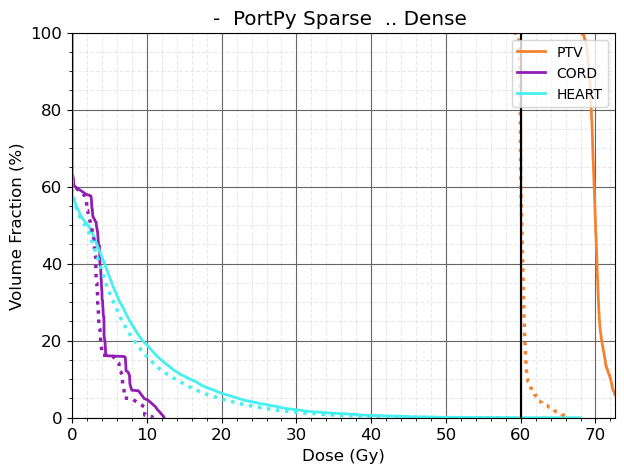

Done!


In [28]:
#  DVH

dose_full = plan_full.inf_matrix.A @ x_full
dose_sparse = plan_full.inf_matrix.A @ x_sparse


fig, ax = plt.subplots(figsize=(7, 5))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_sparse, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_full, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('-  PortPy Sparse  .. Dense ')
plt.show()
print('Done!')

In [30]:
sol_ls_A_full = scipy.sparse.linalg.lsqr(A_dense, dose_sparse_1d)
x_A_full = sol_ls_A_full[0]

relative_error = np.linalg.norm(x_A_full - x_sparse) / np.linalg.norm(x_A_full)
print("خطای نسبی بین دو بردار:", relative_error)


خطای نسبی بین دو بردار: 0.15216012218936803


In [25]:
##  بررسی  پراکندگی ماتریس

is_sparse = sparse.issparse(S)
is_sparse

True

In [8]:
sol_ls_A_full = scipy.sparse.linalg.lsqr(A_full, dose_sparse_1d)
x_A_full = sol_ls_A_full[0]
#error = x_A_full - x_sparse 
#error[0:6]

In [9]:
print(f'x_sparse = {x_sparse.shape} \tx_A_full =  {x_A_full.shape}  \td = {d.shape}')
print(f'\nx_sparse = {x_sparse.ndim}   \tx_A_full =  {x_A_full.ndim}\t d = {d.ndim}')

x_sparse = (542,) 	x_A_full =  (542,)  	d = (60183,)

x_sparse = 1   	x_A_full =  1	 d = 1


In [10]:
x_sparse = sol_ls_A_sparse[0]
print(f'x_sparse :\t {x_sparse[0:6]}')


x_sparse :	 [ 9.62226636  2.36910471  2.05475162  2.7434795  17.12041277  9.16261768]


In [11]:
#  تعداد عناصر غیر صفر

num_non_zero_elements_dense = np.count_nonzero(S @ A)/293764
print("تعداد عناصر غیر صفر در ماتریس S.A:", num_non_zero_elements_dense)

num_non_zero_elements_A_full = np.count_nonzero(A)/32619186
print("تعداد عناصر غیر صفر در ماتریس کامل:", num_non_zero_elements_A_full)
num_non_zero_elements_dense = S.getnnz()/32619186
print("تعداد عناصر غیر صفر در ماتریس portpy_sparse:", num_non_zero_elements_dense)

تعداد عناصر غیر صفر در ماتریس S.A: 0.619340695251971
تعداد عناصر غیر صفر در ماتریس کامل: 0.010287595772622898
تعداد عناصر غیر صفر در ماتریس portpy_sparse: 0.010287595772622898


In [12]:
start_time = time.time()

sol_ls_A_Sparse= scipy.sparse.linalg.lsqr(S @ A,S @ d)


end_time = time.time()

total_execution_time = end_time - start_time
print(f"زمان حل کمترین مربعات{total_execution_time} ثانیه")

زمان حل کمترین مربعات0.7145979404449463 ثانیه


In [13]:
cost = cp.sum_squares((A @ x_A_full  - A @ x_sparse  )/ cp.norm(A @ x_A_full))
prob = cp.Problem(Minimize(cost))
prob.solve()

0.026204946522896688

In [37]:
cost = cp.sum_squares((d  - A @ x_sparse  )/ cp.norm(d))
prob_2 = cp.Problem(Minimize(cost))
sol= prob_2.solve(solver='MOSEK', verbose=True)

                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Dec 20 08:56:46 PM: Your problem has 0 variables, 0 constraints, and 0 parameters.
(CVXPY) Dec 20 08:56:46 PM: It is compliant with the following grammars: DCP, DGP, DQCP
(CVXPY) Dec 20 08:56:46 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Dec 20 08:56:46 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Dec 20 08:56:46 PM: Compiling problem (target solver=CONSTANT_SOLVER).
(CVXPY) Dec 20 08:56:46 PM: Reduction chain: ConstantSolver
(CVXPY) Dec 20 08:56:

In [15]:
import cvxpy as cp

x_A_full = sol_ls_A_full[0]
print(f'x_A_full :\t {x_A_full[0:6]}')

cost = cp.norm(A @ x_A_full - A @ x_sparse, "fro")/ cp.norm(A @ x_A_full, "fro")

prob = cp.Problem(cp.Minimize(cost))
 
prob.solve()


x_A_full :	 [ 6.52999074e+00  1.88267108e-01 -2.44620163e-05 -2.47787551e-05
  1.44560819e+01  7.47028212e+00]


0.16187941970150713

In [16]:
x_sparse = sol_ls_A_Sparse[0]
cost = sum_squares(A @ x_sparse -  d)
prob_original = Problem(Minimize(cost))
prob_original.solve()

88276.63467348814

In [17]:
def calculate_relative_error(vector1, vector2):
   
    array1 = np.array(x_A_full)
    array2 = np.array(x_sparse)

    norm_vector2 = np.linalg.norm(x_A_full)

    relative_error = np.linalg.norm(array1 - array2) / norm_vector2

    return relative_error

error = calculate_relative_error(x_A_full, x_sparse)
print(f"نرم خطای نسبی بین دو بردار: {error}")


نرم خطای نسبی بین دو بردار: 0.15216846525413494


In [18]:
## تابع (هدف)خطای میانگین مربعات
## MSE = Mean Squared Error


d_true = d          # دوز واقعی
d_pred = A @ x_sparse   # دوز پیش‌بینی شده

MSE = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE)



Mean Squared Error : 1.4668034939017354


In [19]:
## تابع (هدف)خطای میانگین مربعات
## MSE = Mean Squared Error

d_true = A @ x_A_full         # دوز واقعی
d_pred = A @ x_sparse   # دوز پیش‌بینی شده

MSE = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE)


Mean Squared Error : 3.7347394046163362


In [25]:
import numpy as np

def calculate_absolute_error(vector1, vector2):
    array1 = np.array(x_A_full)
    array2 = np.array(x_sparse)

    absolute_error = np.linalg.norm(array1 - array2, ord=1) 

    return absolute_error


error = calculate_absolute_error(x_A_full, x_sparse)
print(f"نرم خطای مطلق بین دو بردار: {error}")


نرم خطای مطلق بین دو بردار: 707.3579014333015


In [26]:
import numpy as np
from scipy.optimize import linprog

start_time = time.time()

c = np.ones(A_sparse.shape[1])  # تابع هدف معمولاً یک بردار تمام یک‌ها است
  
result = linprog(c, A_eq=A_sparse, b_eq=dose_full_1d, bounds=(0, None))
 
x_opt = result.x
print("بردار بهینه x:", x_opt)

end_time = time.time()
total_execution_time = end_time - start_time
print(f"زمان کل اجرای نرم یک ماتریس پراکنده  \n: {total_execution_time} ثانیه")

بردار بهینه x: None
زمان کل اجرای نرم یک ماتریس پراکنده  
: 0.10984921455383301 ثانیه


In [27]:
memory_usage_sol_ls_sparse = sys.getsizeof(sol_ls_A_sparse )
megabyte_size_sol_ls_sparse = memory_usage_sol_ls_sparse / 1024 / 1024

print(f"میزان حافظه sol_ls_JL_1 : {megabyte_size_sol_ls_sparse} مگابایت")

میزان حافظه sol_ls_JL_1 : 0.00011444091796875 مگابایت


In [28]:
memory_usage_A_sparse = sys.getsizeof(S )
megabyte_size_A_sparse= memory_usage_A_sparse / 1024 / 1024

print(f"میزان حافظه ساخت JL_1 : {megabyte_size_A_sparse} مگابایت")

میزان حافظه ساخت JL_1 : 4.57763671875e-05 مگابایت


In [29]:
r1 = np.linalg.matrix_rank(S @ A_full ) 
#r2 = np.linalg.matrix_rank(A_full)      
print( f' رتبه ماتریس تقریب = {r1}')

 رتبه ماتریس تقریب = 542


In [30]:
import numpy as np

def calculate_relative_error(vector1, vector2):
   
    array1 = np.array(x_A_full)
    array2 = np.array(x_sparse)

    norm_vector2 = np.linalg.norm(x_A_full)

    relative_error = np.linalg.norm(x_A_full - x_sparse) / norm_vector2

    return relative_error

error = calculate_relative_error(x_A_full, x_sparse)
print(f"نرم خطای نسبی بین دو بردار: {error}")


نرم خطای نسبی بین دو بردار: 0.15216846525413494
